# Project: Building a Customer Review Analyst with Prompt Engineering
* Notebook by Adam Lang
* Date: 6/27/2024

# Overview
* In this notebook we will utilize GPT models and LangChain to build a customer review analyst with Prompt Engineering.
* We will leverage Langchain and ChatGPT and LangChain output parsers.

## Install dependencies

In [1]:
## imports
!pip install langchain==0.1.19
!pip install langchain-openai==0.1.6
!pip install langchain-community==0.0.38

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## API Tokens
* OpenAI

In [2]:
## enter API key
from getpass import getpass

OPENAI_KEY = getpass('Enter your Open AI key: ')

Enter your Open AI key: ··········


In [3]:
## environment variables
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## LLM Dependencies

In [4]:
from langchain_core.prompts import ChatPromptTemplate #prompt templates
from langchain_openai import ChatOpenAI

In [5]:
## instantiate chatgpt instance
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0.0)

# Project 1: Review Analyst
* **Scenario:** You are tasked with building an AI system for a company to look at customer reviews and perform complex analysis. For each customer review we want to prompt the LLM to do the following:

1. Summarize the customer review, summary should be 3 lines at most.

2. Highlight both positive and negatives of the review.

3. Display sentiment analysis of the review: positive, negative, neutral

4. Display a list of 3 to 5 emotions expressed by the customer in the review.

5. Positive or Neutral Sentiment --> write an email and thank the customer for the nice review.

6. Negative Sentiment --> apologize and write email with appropriate response.

Goal: The output from the LLM should be a neatly structured response using an output parser.

## Access Customer Review Data
* This could be in a database (SQL, NoSQL, etc.)
* This could be in a file store.
* For simplicity the reviews are below in an array.

### Notes about the reviews
* Some are distinctly classified as "positive", "negative" or "neutral" but some can be multi-class.

In [6]:
reviews = [
    f"""
    Just received the Bluetooth speaker I ordered for beach outings, and it's fantastic.
    The sound quality is impressively clear with just the right amount of bass.
    It's also waterproof, which tested true during a recent splashing incident.
    Though it's compact, the volume can really fill the space.
    The price was a bargain for such high-quality sound.
    Shipping was also on point, arriving two days early in secure packaging.
    """,
    f"""
    Purchased a new gaming keyboard because of its rave reviews about responsiveness and backlighting.
    It hasn't disappointed. The keys have a satisfying click and the LED colors are vibrant,
    enhancing my gaming experience significantly. Price-wise, it's quite competitive,
    and I feel like I got a good deal. The delivery was swift, and it came well-protected,
    ensuring no damage during transport.
    """,
    f"""
    Ordered a set of wireless earbuds for running, and they've been a letdown.
    The sound constantly cuts out, and the fit is uncomfortable after only a few minutes of use.
    They advertised a 12-hour battery life, but I'm barely getting four hours.
    Considering the cost, I expected better quality and performance.
    They did arrive on time, but the positives end there. I'm already looking into a return.
    """,
    f"""
    The tablet stand I bought was touted as being sturdy and adjustable,
    but it's anything but. It wobbles with the slightest touch,
    and the angles are not holding up as promised. It feels like a breeze could knock it over.
    It was also pricier than others I've seen, which adds to the disappointment.
    It did arrive promptly, but what's the use if the product doesn't meet basic expectations?
    """,
    f"""
    Needed a new kitchen blender, but this model has been a nightmare.
    It's supposed to handle various foods, but it struggles with anything tougher than cooked vegetables.
    It's also incredibly noisy, and the 'easy-clean' feature is a joke; food gets stuck under the blades constantly.
    I thought the brand meant quality, but this product has proven me wrong.
    Plus, it arrived three days late. Definitely not worth the expense.
    """
]

## Define an Output Parser
* We need to do this so we can inform the LLM the structure of the outputs.

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser ## This is the specific parser we are using
from langchain_core.pydantic_v1 import BaseModel, Field

# define Pydantic Data Structure class for deserialization --> serialization of customer review data
class ReviewAnalysisResponse(BaseModel):
  summary: str = Field(description="A brief summary of the customer review with maximum of 3 lines.")
  positives: list = Field(description="A list showing the positives mentioned by the customer in the review if any - only list a maximum of 3 positive points.")
  negatives: list = Field(description="A list showing the negatives mentioned by the customer in the review if any = only list a maximum of 3 negative points.")
  sentiment: str = Field(description="One word classifying the sentiment of the review, this should be one of 3 classes: positive, negative, or neutral")
  emotions: list = Field(description="A list of 3 to 5 emotions expressed by the customer in the review.")
  email: str = Field(description="A detailed email written to the customer based on the sentiment of their review.")


# setup parser with instructions in the prompt template
parser = PydanticOutputParser(pydantic_object=ReviewAnalysisResponse) #feed the class to the parser

## Create the input prompt for the LLM
* This is the final prompt that includes the directed instructions.

In [8]:
# final prompt with formatting instructions from the parser
prompt_txt = """
            Analyze the given customer review below and generate the response based on the instructions mentioned below in the format instructions.
            Also, remember to write a detailed email response for the email field based on the following conditions:
             - email should start with 'Dear Customer,' and signed at the end with 'Service Agent'
             - thank the customer if the classified sentiment of their review was positive or neutral
             - apologize to the customer if the classified sentiment of their review was negative

             Format Instructions:
             {format_instructions}

             Review:
             {review}

"""


# instantiate the prompt template
prompt = PromptTemplate(
    template=prompt_txt,
    input_variables=['review'],
    partial_variables={'format_instructions': parser.get_format_instructions()}
)

## LCEL LLM Chain Creation
* We do this to pass the prompt to the LLM

In [9]:
# create simple LCEL chain to take input prompt --> pass to LLM --> enforce the desired response format using output parser
chain = (prompt
           |
         chatgpt
           |
         parser)

## Format input reviews

In [10]:
# list format --> recall that 'review' is the variable from the final prompt
reviews_formatted = [{'review': review} for review in reviews]
reviews_formatted[0]

{'review': "\n    Just received the Bluetooth speaker I ordered for beach outings, and it's fantastic.\n    The sound quality is impressively clear with just the right amount of bass.\n    It's also waterproof, which tested true during a recent splashing incident.\n    Though it's compact, the volume can really fill the space.\n    The price was a bargain for such high-quality sound.\n    Shipping was also on point, arriving two days early in secure packaging.\n    "}

## Get responses from LLM

In [11]:
# invoke the responses using langchain
responses = chain.map().invoke(reviews_formatted)

## View LLM responses

In [12]:
responses[0]

ReviewAnalysisResponse(summary='Customer is extremely satisfied with the Bluetooth speaker purchased for beach outings.', positives=['Impressively clear sound quality with just the right amount of bass', 'Waterproof feature tested true during a recent splashing incident', 'Compact size with the ability to fill the space with volume'], negatives=[], sentiment='positive', emotions=['Excitement', 'Satisfaction', 'Surprise'], email='Dear Customer, Thank you for your positive review of the Bluetooth speaker you purchased for beach outings. We are thrilled to hear that you are satisfied with the sound quality, waterproof feature, and compact size of the speaker. Your feedback is greatly appreciated. If you have any further questions or need assistance, please feel free to reach out to us. Thank you for choosing our product. Service Agent')

In [16]:
## also as a dict
responses[0].dict()

{'summary': 'Customer is extremely satisfied with the Bluetooth speaker purchased for beach outings.',
 'positives': ['Impressively clear sound quality with just the right amount of bass',
  'Waterproof feature tested true during a recent splashing incident',
  'Compact size with the ability to fill the space with volume'],
 'negatives': [],
 'sentiment': 'positive',
 'emotions': ['Excitement', 'Satisfaction', 'Surprise'],
 'email': 'Dear Customer, Thank you for your positive review of the Bluetooth speaker you purchased for beach outings. We are thrilled to hear that you are satisfied with the sound quality, waterproof feature, and compact size of the speaker. Your feedback is greatly appreciated. If you have any further questions or need assistance, please feel free to reach out to us. Thank you for choosing our product. Service Agent'}

In [13]:
## get responses
for response in responses:
  for k,v in response.dict().items():
    print(f'{k}\n{v}')
    print('----------') ## space
    print('\n')

summary
Customer is extremely satisfied with the Bluetooth speaker purchased for beach outings.
----------


positives
['Impressively clear sound quality with just the right amount of bass', 'Waterproof feature tested true during a recent splashing incident', 'Compact size with the ability to fill the space with volume']
----------


negatives
[]
----------


sentiment
positive
----------


emotions
['Excitement', 'Satisfaction', 'Surprise']
----------


email
Dear Customer, Thank you for your positive review of the Bluetooth speaker you purchased for beach outings. We are thrilled to hear that you are satisfied with the sound quality, waterproof feature, and compact size of the speaker. Your feedback is greatly appreciated. If you have any further questions or need assistance, please feel free to reach out to us. Thank you for choosing our product. Service Agent
----------


summary
Customer is highly satisfied with the new gaming keyboard purchased.
----------


positives
['Responsiv

### Extract this to a dataframe

In [18]:
import pandas as pd

df = pd.DataFrame(response.dict() for response in responses)
df

,summary,positives,negatives,sentiment,emotions,email
0,Customer is extremely satisfied with the Bluet...,[Impressively clear sound quality with just th...,[],positive,"[Excitement, Satisfaction, Surprise]","Dear Customer, Thank you for your positive rev..."
1,Customer is highly satisfied with the new gami...,"[Responsive keys, Vibrant LED backlighting, Co...",[],positive,"[satisfaction, excitement]","Dear Customer, Thank you for your positive rev..."
2,Customer is disappointed with the wireless ear...,[Arrived on time],"[Sound quality issues, Uncomfortable fit, Shor...",negative,"[disappointed, frustrated, unhappy]","Dear Customer, We are truly sorry to hear abou..."
3,Customer is disappointed with the tablet stand...,[],[The tablet stand wobbles easily with the slig...,negative,"[disappointed, frustrated]","Dear Customer, We are truly sorry to hear abou..."
4,Customer is dissatisfied with the kitchen blen...,[],"[Struggles with tougher foods, Incredibly nois...",negative,"[frustration, disappointment]","Dear Customer, We are truly sorry to hear abou..."


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   summary    5 non-null      object
 1   positives  5 non-null      object
 2   negatives  5 non-null      object
 3   sentiment  5 non-null      object
 4   emotions   5 non-null      object
 5   email      5 non-null      object
dtypes: object(6)
memory usage: 368.0+ bytes


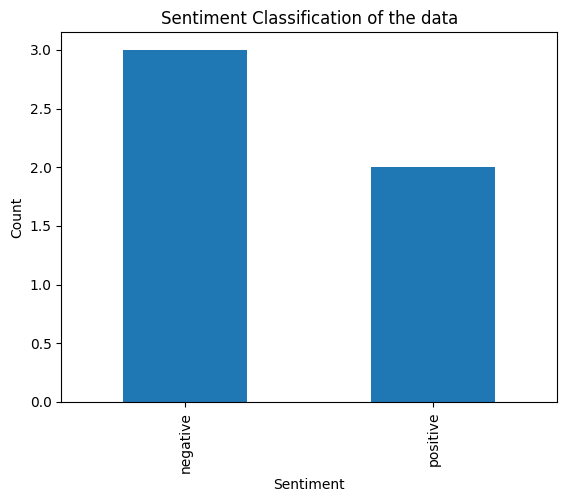

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
df.sentiment.value_counts().plot(kind='bar')
plt.title("Sentiment Classification of the data")
plt.ylabel("Count")
plt.xlabel('Sentiment')
plt.show();

# Summary
* Now if we wanted to benchmark these findings, we could take the labeled data and perform further analysis.
* One thing we might want to do is take the reviews by each customer and perform topic modeling to see some of the common topics they discuss in their reviews.
* Another thing we might want to do is check the model outputs by comparing it to a more classical machine learning model by first cleaning the text and then tokenizing it and then performing multi-class classification. The zero-shot prompting that we did above is a great tool for labeling the data.
* We may also want delve further into why there are more negative reviews than positive, was there a common issue each customer noted?